In [227]:
import sys
import os
current_path = os.getcwd()  # 获取当前工作目录
print("当前路径:", current_path)
current_path = current_path.replace('/samples', '')
print(sys.path)  # 显示所有模块搜索路径
sys.path.append(current_path)  # 添加自定义路径
print(sys.path)  # 显示所有模块搜索路径

当前路径: /Users/yang/PycharmProjects/Option/samples
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/Users/yang/PycharmProjects/Option', '/Users/yang/PycharmProjects/Option', '/Users/yang/PycharmProjects/Option', '/Users/yang/PycharmProjects/Option']
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '

In [228]:
import pandas as pd
import numpy as np
import QuantLib as ql
import math
from datetime import datetime

from src.QlCalendar import QlCalendar
from src.QlStocks import QlStocks
from src.QlEuropeanOptions import QlEuropeanOptions
from src.utils import plot_multi_y_axis, unix_time_to_ql_dates

In [229]:
df = pd.read_feather(r'../data/tsla_2019_2022.feather')
len(df)

1054723

In [230]:
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
df['EXPIRE_DATE'] = pd.to_datetime(df['EXPIRE_DATE'])
# 计算日期差值（返回 timedelta 类型，如 "XX days"）
df['DAYS_DIFFERENCE'] = df['EXPIRE_DATE'] - df['QUOTE_DATE']

# 提取天数（数值形式）
df['DAYS_DIFFERENCE'] = df['DAYS_DIFFERENCE'].dt.days

In [231]:
df = df[df['DAYS_DIFFERENCE'] >= 15]

In [232]:
df = df.sort_values(['QUOTE_DATE', 'DAYS_DIFFERENCE', 'STRIKE_DISTANCE'])

In [233]:
df

,QUOTE_UNIXTIME,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,...,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,DAYS_DIFFERENCE
1536614,1546462800,2019-01-02,310.12,2019-01-18,1547845200,0.52279,0.00988,0.26405,-0.47519,0.06357,...,-0.47772,0.01033,0.26452,-0.47896,-0.07505,0.58251,727.0,0.1,0.000,16
1536615,1546462800,2019-01-02,310.12,2019-01-18,1547845200,0.49784,0.01004,0.26422,-0.47118,0.06114,...,-0.50305,0.01025,0.26448,-0.48177,-0.07927,0.58425,49.0,2.4,0.008,16
1536616,1546462800,2019-01-02,310.12,2019-01-18,1547845200,0.47236,0.01005,0.26378,-0.46395,0.05845,...,-0.53009,0.01047,0.26367,-0.47056,-0.08345,0.57134,173.0,4.9,0.016,16
1536613,1546462800,2019-01-02,310.12,2019-01-18,1547845200,0.57203,0.00951,0.25995,-0.47512,0.06865,...,-0.42577,0.00992,0.26032,-0.47704,-0.06613,0.59162,261.0,5.1,0.017,16
1536617,1546462800,2019-01-02,310.12,2019-01-18,1547845200,0.44661,0.01013,0.26194,-0.45725,0.05625,...,-0.55620,0.01038,0.26211,-0.46610,-0.08805,0.56977,93.0,7.4,0.024,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138985,1672434000,2022-12-30,123.19,2023-02-17,1676667600,0.00090,0.00005,0.00137,-0.00127,0.00056,...,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,456.8,3.708,49
1138986,1672434000,2022-12-30,123.19,2023-02-17,1676667600,0.00086,0.00002,0.00119,-0.00191,0.00044,...,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,461.8,3.749,49
1138987,1672434000,2022-12-30,123.19,2023-02-17,1676667600,0.00062,0.00008,0.00134,-0.00165,-0.00007,...,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,466.8,3.789,49
1138988,1672434000,2022-12-30,123.19,2023-02-17,1676667600,0.00071,0.00001,0.00160,-0.00140,-0.00022,...,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,471.8,3.830,49


## history volatility


In [234]:
stock_prices_df = df.drop_duplicates('QUOTE_DATE')[['QUOTE_DATE', 'EXPIRE_DATE', 'DAYS_DIFFERENCE', 'UNDERLYING_LAST', 'C_IV', 'P_IV', 'STRIKE']]
stock_prices_df.reset_index(drop=True, inplace=True)

In [235]:
stock_prices_df

,QUOTE_DATE,EXPIRE_DATE,DAYS_DIFFERENCE,UNDERLYING_LAST,C_IV,P_IV,STRIKE
0,2019-01-02,2019-01-18,16,310.12,0.60717,0.58251,310.00
1,2019-01-03,2019-01-18,15,300.37,0.60837,0.59797,300.00
2,2019-01-04,2019-01-25,21,317.67,0.55135,0.53798,317.50
3,2019-01-07,2019-01-25,18,334.97,0.55181,0.53528,335.00
4,2019-01-08,2019-01-25,17,335.29,0.53803,0.52422,335.00
...,...,...,...,...,...,...,...
1005,2022-12-26,2023-01-13,18,123.15,0.94651,0.85546,125.00
1006,2022-12-27,2023-01-13,17,109.08,0.99104,0.98917,110.00
1007,2022-12-28,2023-01-13,16,112.72,0.95529,0.95919,113.00
1008,2022-12-29,2023-01-13,15,121.82,0.89431,0.90737,122.00


<Axes: >

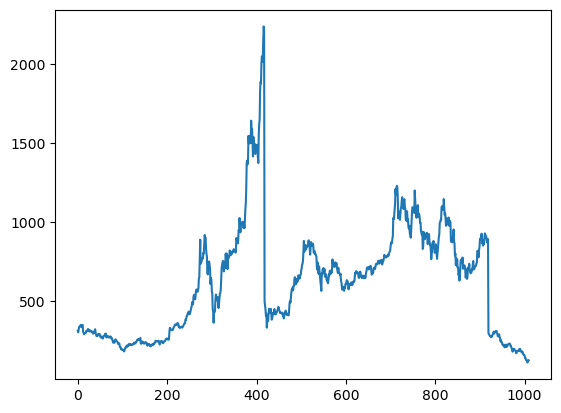

In [236]:
stock_prices_df['UNDERLYING_LAST'].plot()

In [237]:
stock_prices_df[stock_prices_df['QUOTE_DATE'] >= '2020-08-28']

,QUOTE_DATE,EXPIRE_DATE,DAYS_DIFFERENCE,UNDERLYING_LAST,C_IV,P_IV,STRIKE
417,2020-08-28,2020-09-18,21,2213.40,0.88987,0.89759,2225.00
418,2020-08-31,2020-09-18,18,498.41,0.98528,0.98058,500.00
419,2020-09-01,2020-09-18,17,475.04,1.12390,1.12450,475.00
420,2020-09-02,2020-09-18,16,447.25,1.13690,1.11990,445.00
421,2020-09-03,2020-09-18,15,407.00,1.11936,1.12284,407.00
...,...,...,...,...,...,...,...
1005,2022-12-26,2023-01-13,18,123.15,0.94651,0.85546,125.00
1006,2022-12-27,2023-01-13,17,109.08,0.99104,0.98917,110.00
1007,2022-12-28,2023-01-13,16,112.72,0.95529,0.95919,113.00
1008,2022-12-29,2023-01-13,15,121.82,0.89431,0.90737,122.00


# 股票拆分

2020-08-28 1 - 5

2022-08-24 1 - 3

In [238]:
split = np.where(stock_prices_df['QUOTE_DATE'] <= '2020-08-28', 5, 1)
split = np.where(stock_prices_df['QUOTE_DATE'] <= '2022-08-24', split * 3, split)
stock_prices_df['split'] = split

<Axes: >

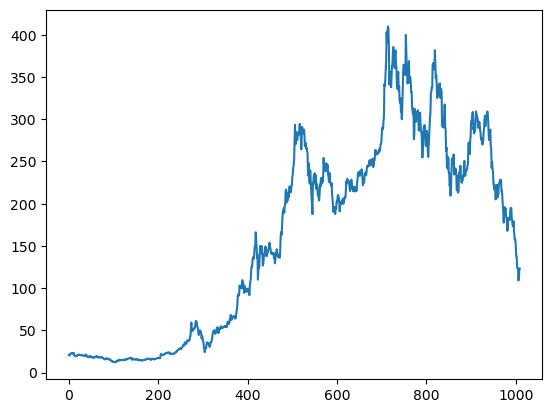

In [239]:
splited_prices = (stock_prices_df['UNDERLYING_LAST'] / stock_prices_df['split'])
stock_prices_df['splited_prices'] = splited_prices
splited_prices.plot()

In [240]:
def calculate_historical_volatility(prices, window=252, trading_days=252):
    """
    计算历史波动率

    参数:
    prices: 价格序列 (pd.Series或list)
    window: 计算窗口大小 (默认252天)
    trading_days: 年化交易日数 (默认252)

    返回:
    历史波动率 (年化)
    """
    # 转换为对数收益率
    if not isinstance(prices, pd.Series):
        prices = pd.Series(prices)
    returns = np.log(prices / prices.shift(1))

    # 计算滚动标准差
    rolling_std = returns.rolling(window=window).std()

    # 年化波动率
    historical_volatility = rolling_std * np.sqrt(trading_days)

    return historical_volatility

In [241]:
stock_prices_df['HV'] = calculate_historical_volatility(splited_prices)

In [242]:
stock_prices_df = stock_prices_df[stock_prices_df['HV'].notnull()]
stock_prices_df

,QUOTE_DATE,EXPIRE_DATE,DAYS_DIFFERENCE,UNDERLYING_LAST,C_IV,P_IV,STRIKE,split,splited_prices,HV
252,2020-01-02,2020-01-17,15,430.24,0.46220,0.45318,430.00,15,28.682667,0.490530
253,2020-01-03,2020-01-24,21,442.75,0.42448,0.40605,442.50,15,29.516667,0.490150
254,2020-01-06,2020-01-24,18,451.40,0.43340,0.42182,452.50,15,30.093333,0.487425
255,2020-01-07,2020-01-24,17,469.17,0.46151,0.45352,470.00,15,31.278000,0.486103
256,2020-01-08,2020-01-24,16,492.09,0.53828,0.53437,490.00,15,32.806000,0.488308
...,...,...,...,...,...,...,...,...,...,...
1005,2022-12-26,2023-01-13,18,123.15,0.94651,0.85546,125.00,1,123.150000,0.654713
1006,2022-12-27,2023-01-13,17,109.08,0.99104,0.98917,110.00,1,109.080000,0.651898
1007,2022-12-28,2023-01-13,16,112.72,0.95529,0.95919,113.00,1,112.720000,0.651907
1008,2022-12-29,2023-01-13,15,121.82,0.89431,0.90737,122.00,1,121.820000,0.655136


<Axes: >

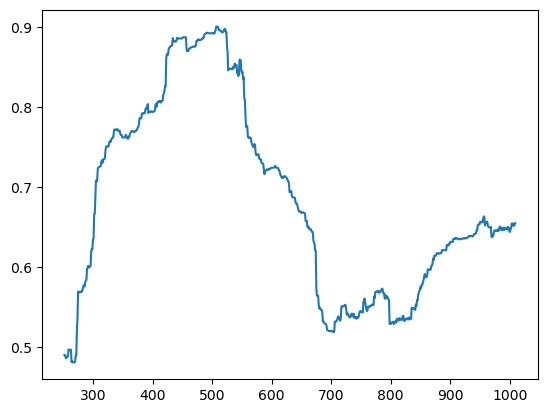

In [243]:
stock_prices_df['HV'].plot()

## 2020

In [244]:
df_2020 = stock_prices_df[(stock_prices_df['QUOTE_DATE'] >= '2020-01-01') & (stock_prices_df['QUOTE_DATE'] <= '2020-12-31')]
len(df_2020)

250

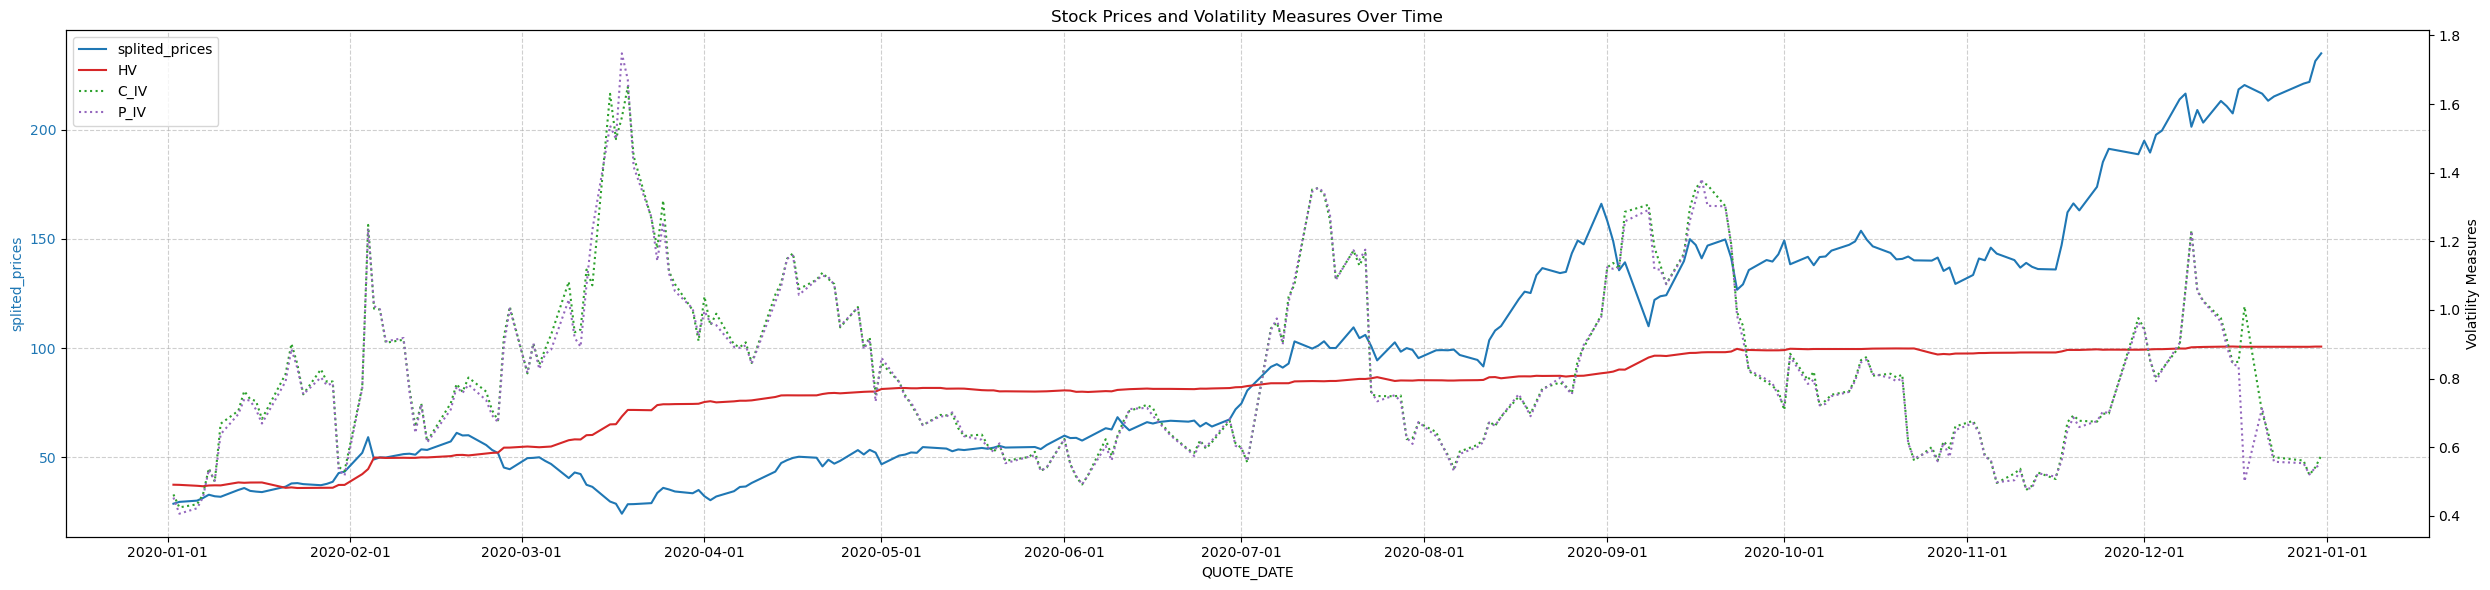

In [245]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt_df = df_2020
# plt_df['QUOTE_DATE'] = pd.to_datetime(plt_df['QUOTE_DATE'])  # 自动识别 'YYYY-MM-DD' 格式

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(25, 6))

# Plot splited_prices on left y-axis
color = 'tab:blue'
ax1.set_xlabel('QUOTE_DATE')
ax1.set_ylabel('splited_prices', color=color)
ax1.plot(plt_df['QUOTE_DATE'], plt_df['splited_prices'],
         linestyle='-', color=color, label='splited_prices')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot HV, C_IV, P_IV on right y-axis
colors = ['tab:red', 'tab:green', 'tab:purple']
for col, color, linestyle in zip(['HV', 'C_IV', 'P_IV'],
                                colors,
                                ['-', ':', ':']):
    ax2.plot(plt_df['QUOTE_DATE'], plt_df[col],
             linestyle=linestyle, color=color, label=col)

ax2.set_ylabel('Volatility Measures', color='black')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 改进部分：调整x轴日期显示密度
# 方法1：按月显示（每月1个标签）
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 每月显示一个标签
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期
ax1.grid(True, linestyle='--', alpha=0.6)

# Format x-axis dates
plt.xticks(rotation=45)
# fig.autofmt_xdate()

# Title
plt.title('Stock Prices and Volatility Measures Over Time')

plt.tight_layout()
plt.show()

## 2021

In [246]:
df_2021 = stock_prices_df[(stock_prices_df['QUOTE_DATE'] >= '2021-01-01') & (stock_prices_df['QUOTE_DATE'] <= '2021-12-31')]
len(df_2021)

252

/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_26097/2191183375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_df['QUOTE_DATE'] = pd.to_datetime(plt_df['QUOTE_DATE'])  # 自动识别 'YYYY-MM-DD' 格式


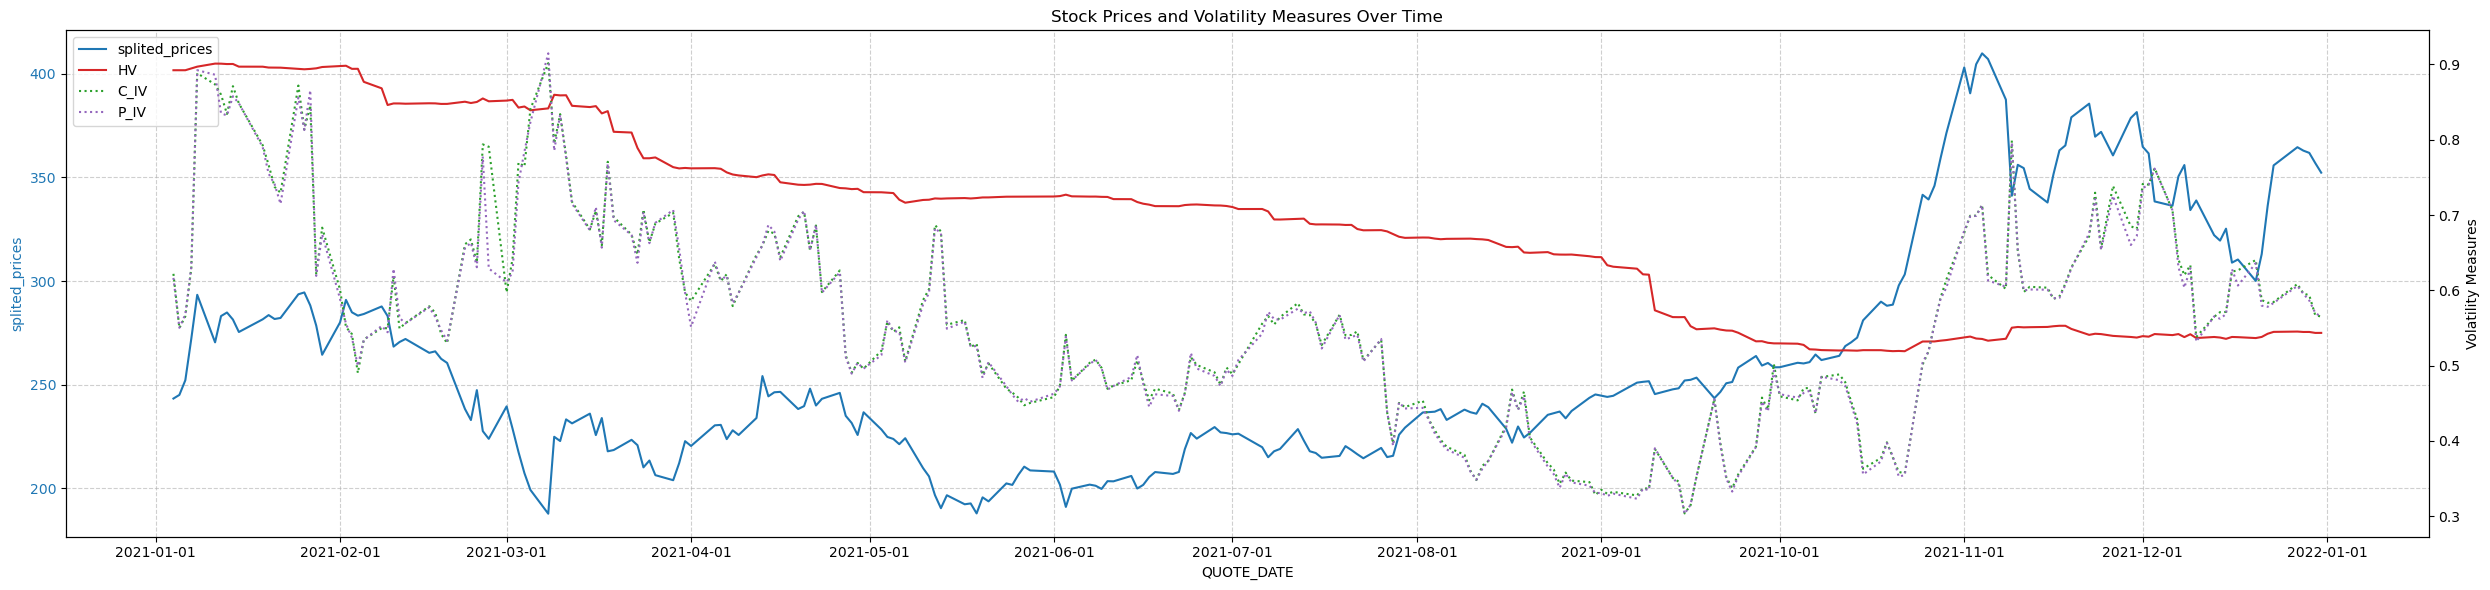

In [247]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt_df = df_2021
plt_df['QUOTE_DATE'] = pd.to_datetime(plt_df['QUOTE_DATE'])  # 自动识别 'YYYY-MM-DD' 格式

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(25, 6))

# Plot splited_prices on left y-axis
color = 'tab:blue'
ax1.set_xlabel('QUOTE_DATE')
ax1.set_ylabel('splited_prices', color=color)
ax1.plot(plt_df['QUOTE_DATE'], plt_df['splited_prices'],
         linestyle='-', color=color, label='splited_prices')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot HV, C_IV, P_IV on right y-axis
colors = ['tab:red', 'tab:green', 'tab:purple']
for col, color, linestyle in zip(['HV', 'C_IV', 'P_IV'],
                                colors,
                                ['-', ':', ':']):
    ax2.plot(plt_df['QUOTE_DATE'], plt_df[col],
             linestyle=linestyle, color=color, label=col)

ax2.set_ylabel('Volatility Measures', color='black')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 改进部分：调整x轴日期显示密度
# 方法1：按月显示（每月1个标签）
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 每月显示一个标签
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期
ax1.grid(True, linestyle='--', alpha=0.6)

# Format x-axis dates
plt.xticks(rotation=45)
# fig.autofmt_xdate()

# Title
plt.title('Stock Prices and Volatility Measures Over Time')

plt.tight_layout()
plt.show()

In [248]:
plt_df

,QUOTE_DATE,EXPIRE_DATE,DAYS_DIFFERENCE,UNDERLYING_LAST,C_IV,P_IV,STRIKE,split,splited_prices,HV
502,2021-01-04,2021-01-22,18,729.77,0.62194,0.61653,730.0,3,243.256667,0.892313
503,2021-01-05,2021-01-22,17,735.05,0.54986,0.55025,735.0,3,245.016667,0.892314
504,2021-01-06,2021-01-22,16,756.32,0.56554,0.56816,755.0,3,252.106667,0.892315
505,2021-01-07,2021-01-22,15,816.29,0.62906,0.63082,815.0,3,272.096667,0.894658
506,2021-01-08,2021-01-29,21,880.03,0.88833,0.89238,880.0,3,293.343333,0.897058
...,...,...,...,...,...,...,...,...,...,...
749,2021-12-27,2022-01-14,18,1093.82,0.60846,0.60584,1095.0,3,364.606667,0.545264
750,2021-12-28,2022-01-14,17,1088.85,0.59595,0.59552,1090.0,3,362.950000,0.544734
751,2021-12-29,2022-01-14,16,1085.56,0.59336,0.58647,1085.0,3,361.853333,0.544754
752,2021-12-30,2022-01-14,15,1070.85,0.56694,0.57003,1070.0,3,356.950000,0.543476
